In [365]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.animation as animation
from typing import Tuple, List


In [366]:
class Vortex: 
    def __init__(self, gamma: float, center_x: float, center_y: float):
        self.gamma = gamma
        self.center_x = center_x
        self.center_y = center_y

    def get_polar(self, center_x: float, center_y: float, coord_x: int, coord_y: int) -> Tuple[float, float]:
        r = np.sqrt((coord_x - center_x)**2 + (coord_y - center_y)**2)
        theta = np.arctan2((coord_y - center_y), (coord_x - center_x))
        return (r, theta)

    def apply_phantom_vortex(self, coord_x: int, coord_y: int, copy_x: int, copy_y: int) -> Tuple[float, float]:
        phantom_gamma = -self.gamma
        phantom_r, phantom_theta = self.get_polar(copy_x, copy_y, coord_x, coord_y)
        u_theta_x = 0
        u_theta_y = 0
        if 0 < phantom_r and phantom_r < 25:
            u_theta = phantom_gamma/(2*np.pi*phantom_r)
            u_theta_x = -u_theta*np.sin(phantom_theta)
            u_theta_y = u_theta*np.cos(phantom_theta)
        
        return (u_theta_x, u_theta_y)


    def generate_vectorfield(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # GIVEN a vectorfield, generate the change in the vectorfield caused by this vortex
        U_matrix = np.zeros_like(x)
        V_matrix = np.zeros_like(y)
        for i in range(len(x)):
            for j in range(len(x[i])):
                r, theta = self.get_polar(self.center_x, self.center_y, x[i][j], y[i][j])
                u_theta_x = 0.0
                u_theta_y = 0.0
                if 0 < r and r < 25:
                    u_theta = self.gamma/(2*np.pi*r)
                    u_theta_x = -u_theta*np.sin(theta)
                    u_theta_y = u_theta*np.cos(theta)

                if i < 25:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, -self.center_x, self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p
                if i > len(x) - 26:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, 2 * len(x) - self.center_x, self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p
                if j < 25:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, self.center_x, -self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p
                if j > len(y[i]) - 26:
                    u_theta_x_p, u_theta_y_p = self.apply_phantom_vortex(i, j, self.center_x, 2 * len(y[i]) - self.center_y)
                    u_theta_x += u_theta_x_p
                    u_theta_y += u_theta_y_p

                U_matrix[i][j] = u_theta_x
                V_matrix[i][j] = u_theta_y
        return (U_matrix, V_matrix)

class Field:
    def __init__(self, x_dim: int, y_dim: int, vortices: List[Vortex]):
        self.vortices = vortices
        self.x = np.zeros((x_dim, y_dim), dtype=float)
        self.y = np.zeros((x_dim, y_dim), dtype=float)

    def move_timestep(self, dt: float):
        # 1. Calculate vectorfields of all vortices
        U_matrix = np.zeros_like(self.x, dtype=float)
        V_matrix = np.zeros_like(self.y, dtype=float)
        for vort in self.vortices:
            X, Y = vort.generate_vectorfield(self.x, self.y)
            # 2. Sum them up on the overall vectorfield
            U_matrix += (X * dt)
            V_matrix += (Y * dt)

        self.x += U_matrix
        self.y += V_matrix

        # 3. Move the vortices
        for i in range(len(self.vortices)):
            closest_i = int(round(self.vortices[i].center_x)) - 1
            closest_j = int(round(self.vortices[i].center_y)) - 1
            self.vortices[i].center_x += U_matrix[closest_i][closest_j]
            self.vortices[i].center_y += V_matrix[closest_i][closest_j]
            


U min: -0.05953394694825198 U max: 0.011571374679514732
V min: -0.07027512188956288 V max: 0.003242351157104823
set_UVC called
set_UVC called


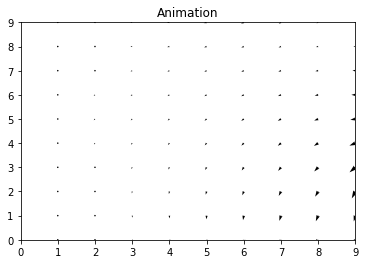

In [367]:
# Set up the grid for the vector field
vortex1 = Vortex(1, 5 , 7)
vortex2 = Vortex(-1, 9 , 2)
field = Field(10, 10, [vortex1, vortex2])
field.move_timestep(1.0)
U = field.x 
V = field.y 
print("U min:", np.min(U), "U max:", np.max(U))
print("V min:", np.min(V), "V max:", np.max(V))

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, 9)
ax.set_ylim(0, 9)
ax.set_title("Animation")
mesh_x, mesh_y = np.mgrid[:len(field.x), :len(field.x[0])]
quiver = ax.quiver(mesh_x, mesh_y, U, V, scale=10, width=0.005)

# Animation function to update U and V at each frame
def animate(frame):
    # update field
    field.move_timestep(1.0)
    U = field.x 
    V = field.y

    
    quiver.set_UVC(U,V)
    print("set_UVC called")

    return quiver,

ani = animation.FuncAnimation(fig, animate, frames=range(100), interval=100, blit=True, cache_frame_data=False, repeat=True)
plt.show()


<ipython-input-368-2647becc17b9>:29: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, X, Y),


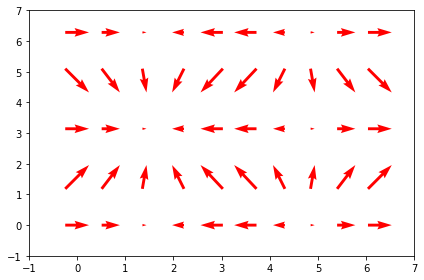

In [368]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

X, Y = np.mgrid[:2*np.pi:10j,:2*np.pi:5j]
U = np.cos(X)
V = np.sin(Y)

fig, ax = plt.subplots(1,1)
Q = ax.quiver(X, Y, U, V, pivot='mid', color='r', units='inches')

ax.set_xlim(-1, 7)
ax.set_ylim(-1, 7)

def update_quiver(num, Q, X, Y):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """

    U = np.cos(X + num*0.1)
    V = np.sin(Y + num*0.1)

    Q.set_UVC(U,V)

    return Q,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, X, Y),
                               interval=50, blit=False)
fig.tight_layout()
plt.show()